In [1]:
#######################################################################################################
## Estimation Lynx-Hare dynamics using Lotka-Volterra equation                                       ##   
## Estimates based on QL-ODE-P-splines (Frasso, Jaeger and Lambert, 2015)                            ##
#######################################################################################################

#-------------------------------------------- library -------------------------------------------------#

rm(list = ls()); graphics.off(); cat("\014")
library(splines)
library(Matrix)
library(spam)
library(deSolve)

#------------------------------------- source files ---------------------------------------------------#

source("basis_array.R")
source("functions_to_optimize.R")
source("penalty_function.R")

Loading required package: dotCall64

Loading required package: grid

Spam version 2.5-1 (2019-12-12) is loaded.
Type 'help( Spam)' or 'demo( spam)' for a short introduction 
and overview of this package.
Help for individual functions is also obtained by adding the
suffix '.spam' to the function name, e.g. 'help( chol.spam)'.


Attaching package: ‘spam’


The following object is masked from ‘package:Matrix’:

    det


The following objects are masked from ‘package:base’:

    backsolve, forwardsolve




In [2]:
#------------------------------------------ data and time ---------------------------------------------#

dat = read.delim("lynx.txt", header = F)
dat = dat[20:40, ]

t_obs = seq(0, 20, len = nrow(dat))
n = length(t_obs)

y_obs_1 = dat[, 2] 
y_obs_2 = dat[, 3] 
y_obs = c(y_obs_1, y_obs_2)

N_obs = n * 2

min_t = min(t_obs)
max_t = max(t_obs)

In [5]:
#-------------------------------- design matrix and diff pen ------------------------------------------#

B = basis_array(x = t_obs, xl = min_t, xr = max_t, ndx = ndt, deg = 3, max_derivs = 1, sparse = TRUE)
B_0 = as.spam(as.matrix(B[[1]]))
t_B_0 = t(B_0)

tB_B = t_B_0 %*% B_0

tB_y = t_B_0 %*% cbind(y_obs_1, y_obs_2)

M = dim(tB_B)[2]

D = diff(diag(M), diff = 2)
tD_D = t(D) %*% D

In [6]:
#------------------ Initial smoothing raw data and initial parameters ---------------------------------#

# smoothing for x1 and x2

las = seq(-1, 8, by = .5)
cv = ed = las * 0
i = 1

for(la in las)
{
  lam = 10 ^ la
  solve_A = solve(tB_B +  lam * tD_D)
  cy = solve_A %*% tB_y
  ed[i] = sum(diag(B_0 %*% solve_A %*% t_B_0))
  rss = sum((y_obs - B_0 %*% cy) ^ 2)
  cv[i] = rss/((N_obs - ed[i]) ^ 2)
  i = i + 1
}

lam_opt = 10 ^ las[which.min(cv)]
ck = c(solve(tB_B +  lam_opt * tD_D, tB_y))
tau_in = (N_obs - ed[which.min(cv)])/sum((y_obs - B_0 %*% matrix(ck, ncol = 2))^2)

In [7]:
#--------------------------------- Quasi ODE-P-spline ---------------------------------------------------#

pars = c(0.547, 0.028, 0.843, 0.026, 0.01) # initial parameters as in section 5.2
i = 1
ck = cbind(ck, NULL)
       
theta_tau = c(pars)

crit_gamma = crit_ck = crit_theta_tau = 1
gamma = 1e4

while(((crit_ck > tol_ck) | (crit_gamma > tol_gamma) | (crit_theta_tau > tol_theta_tau)) && (i < 100))
{
  theta_tau_old = theta_tau
  zandpen = c_hat_function(theta = theta_tau[-length(theta_tau)],
                           tau = theta_tau[length(theta_tau)],
                           gamma,
                           ck = ck[, i],
                           length_t,
                           seq_t,
                           B_seq_t,
                           regul = 0.0)

  z = zandpen[[1]]
  pen = zandpen[[2]]
  t_z = t(z)

  y_star = B_0 %*% matrix(z, ncol = 2)
  PEN = (t_z %*% pen $ R %*% z + 2 * t_z %*% pen $ r + pen $ l) 
 
  A = as.matrix(gamma * pen $ R +
                rbind(cbind(tB_B  * theta_tau[length(theta_tau)], tB_B * 0),
                cbind(tB_B * 0, tB_B * theta_tau[length(theta_tau)])))
  solve_A = solve(A, tol = 1e-50)

  ed_1 = sum(diag(B_0 %*% solve_A[1:M, 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))
  ed_2 = sum(diag(B_0 %*% solve_A[M + 1:M, M + 1:M] %*% (theta_tau[length(theta_tau)] * t_B_0)))

  theta_tau[length(theta_tau)] = (N_obs - (ed_1 + ed_2)) / sum((y_obs - c(y_star)) ^ 2)

  den = c(PEN / (ed_1 + ed_2))

  gamma_new = 1 / (den + 1e-15)

  crit_gamma = abs((gamma - gamma_new) / gamma)
  gamma = gamma_new

  ck = cbind(ck, z)
  crit_ck = max(abs((ck[, i] - z) / ck[, i]))

  optim_parm = optim(par = theta_tau[-length(theta_tau)],
                     fn = H_fun,
                     tau =  theta_tau[length(theta_tau)],
                     gamma = gamma,
                     ck = z,
                     length_t = length_t,
                     seq_t = seq_t,
                     B_seq_t = B_seq_t,
                     regul = 0.0,
                     method = "BFGS",
                     control = list(fnscale = -1, trace = FALSE),
                     hessian = TRUE)

  theta_tau[-length(theta_tau)] = optim_parm $ par
  FIM = solve(-optim_parm $ hessian)

  crit_theta_tau = max(abs((theta_tau - theta_tau_old) / theta_tau_old))

  cat('iteration:', i,'\n')
  cat('\t', 'crit_gamma:', round(crit_gamma, 8), '\n')
  cat('\t', 'crit_ck:', round(crit_ck, 8), '\n')
  cat('\t', 'crit_theta_tau:', round(crit_theta_tau, 8), '\n')
  cat('\t', 'gamma:', round(gamma, 8), '\n')
  cat('\t', 'tau:', round(tail(theta_tau, n = 1), 8), '\n')
  cat('\t', 'theta:', head(theta_tau, n = -1), '\n')
  
  i = i+1
}

iteration: 1 
	 crit_gamma: 25.94752 
	 crit_ck: 0.5590712 
	 crit_theta_tau: 3.635369 
	 gamma: 269475.2 
	 tau: 0.04635369 
	 theta: 0.4722384 0.02464432 0.9561514 0.02832944 
iteration: 2 
	 crit_gamma: 0.122136 
	 crit_ck: 0.3005892 
	 crit_theta_tau: 0.457511 
	 gamma: 236562.6 
	 tau: 0.06756101 
	 theta: 0.4785745 0.02478488 0.9322518 0.02773456 
iteration: 3 
	 crit_gamma: 0.1287984 
	 crit_ck: 0.06512094 
	 crit_theta_tau: 0.00387269 
	 gamma: 267031.5 
	 tau: 0.06729937 
	 theta: 0.4785745 0.02478488 0.9322518 0.02773456 
iteration: 4 
	 crit_gamma: 0.00213698 
	 crit_ck: 0.00140344 
	 crit_theta_tau: 0.00015674 
	 gamma: 266460.9 
	 tau: 0.06728882 
	 theta: 0.4785745 0.02478488 0.9322518 0.02773456 
iteration: 5 
	 crit_gamma: 0.00013369 
	 crit_ck: 3.414e-05 
	 crit_theta_tau: 6.29e-06 
	 gamma: 266496.5 
	 tau: 0.0672884 
	 theta: 0.4785745 0.02478488 0.9322518 0.02773456 
iteration: 6 
	 crit_gamma: 2.294e-05 
	 crit_ck: 2.93e-06 
	 crit_theta_tau: 3.1e-07 
	 gamma: 2665

In [14]:
#-------------------------------------- numerical solution --------------------------------------------#

alpha = theta_tau[1]
beta = theta_tau[2]
gam = theta_tau[3]
delta = theta_tau[4]  

pars = c(alpha, beta, gam, delta) 
lotka_volterra = function(Time, State, Pars)
{
  with(as.list(c(State, Pars, t)),
       {
         dx1 = Pars[1] * x1 - Pars[2] * x1 * x2 
         dx2 = -Pars[3] * x2 + Pars[4] * x2 * x1
         dx3 = -Pars[1]
         return(list(c(dx1, dx2)))
       })
}
ini  = c(x1 = y_star[1, 1], x2 = y_star[1, 2])
times = seq_t
out = ode(ini, times, lotka_volterra, pars)

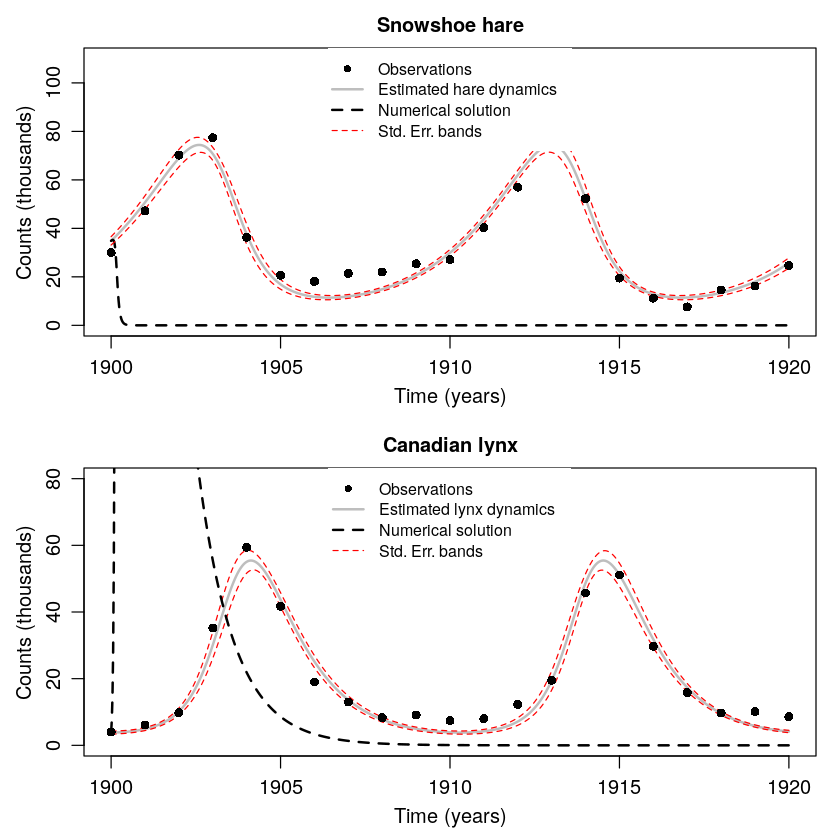

In [15]:

#--------------------------------- plot and approx. std errors ----------------------------------------#

std_err = sqrt(diag(FIM)) # approximate parameter std. error
lev = 0.99
alp = qnorm(1-(1-lev)/2)
sigma = sqrt(1/theta_tau[length(theta_tau)])

par(mfcol = c(2, 1), mar = c(3.5, 3.5, 2, 1), cex.main = 1, mgp = c(2, 0.8, 0))

A = as.matrix(gamma * pen $ R +
                rbind(cbind(tB_B  * theta_tau[length(theta_tau)], tB_B * 0),
                      cbind(tB_B * 0, tB_B * theta_tau[length(theta_tau)])))
solve_A = sigma^2 * solve(A, tol = 1e-50)     

bounds = B_seq_t[[1]] %*% solve_A[1:M, 1:M] %*% t(B_seq_t[[1]] * theta_tau[5])

low_bound = B_seq_t[[1]] %*% ck[1:M, i] - alp * sqrt(diag(bounds))
up_bound = B_seq_t[[1]] %*% ck[1:M, i] + alp * sqrt(diag(bounds))   

plot(t_obs + 1900, y_obs_1, main = "Snowshoe hare",
     xlab = "Time (years)", ylab = "Counts (thousands)", ylim = c(0, 110),
     pch = 16, cex = 1, col = 1)
lines(seq_t + 1900, B_seq_t[[1]] %*% ck[1:M, i], lwd = 2, col = 8)
lines(times + 1900, out[, "x1"], col = 1, lty = 2, lwd = 2)
lines(seq_t + 1900, low_bound, col = 2, lty = 2)
lines(seq_t + 1900, up_bound, col = 2, lty = 2)

points(t_obs + 1900, y_obs_1, col = 1, pch = 16)
legend("top", c("Observations", "Estimated hare dynamics", "Numerical solution",
                    "Std. Err. bands"),
       col = c("black", "gray", "black", "red"), pch = c(16, -1, -1, -1),
       lty = c(0, 1, 2, 2), lwd = c(0, 2, 2, 1), box.lty = 0, cex = 0.8)

bounds = B_seq_t[[1]]  %*% solve_A[M + 1:M, M + 1:M] %*% t(B_seq_t[[1]] * theta_tau[5])

low_bound = B_seq_t[[1]] %*% ck[M + 1:M, i] - alp * sqrt(diag(bounds))
up_bound = B_seq_t[[1]] %*% ck[M + 1:M, i] + alp * sqrt(diag(bounds)) 


plot(t_obs + 1900, y_obs_2, main = "Canadian lynx",
     xlab = "Time (years)", ylab = "Counts (thousands)", ylim = c(0, 80),
     pch = 16, cex = 1, col = 1)
lines(seq_t + 1900, B_seq_t[[1]] %*% ck[M + 1:M, i], lwd = 2, col = 8)
lines(seq_t + 1900, low_bound, col = 2, lty = 2)
lines(seq_t + 1900, up_bound, col = 2, lty = 2)

lines(times + 1900, out[, "x2"], col = 1, lty = 2, lwd = 2)
points(t_obs + 1900, y_obs_2, pch = 16, col = 1)
legend("top", c("Observations", "Estimated lynx dynamics", "Numerical solution",
                    "Std. Err. bands"),
       col = c("black", "gray", "black", "red"), pch = c(16, -1, -1, -1),
       lty = c(0, 1, 2, 2), lwd = c(0, 2, 2, 1), box.lty = 0, cex = 0.8)


